# Logistic Regression 
Welcome to this notebook where we will dive deep into the world of logistic regression. We'll guide you through the process of building, training, and testing a logistic regression classifier. This is a fundamental machine learning algorithm used for solving classification problems, and understanding it will give you a strong foundation in machine learning.

#### Assumed Knowledge
Before proceeding with this notebook, you should be familiar with:

- **Optimisation in Python**: You should know how to use optimization techniques such as gradient descent to find minimum or maximum values of functions. You should be comfortable using libraries like NumPy and Scikit-learn to implement these techniques.

- **Linear Regression**: You should have a grasp on linear regression as we did in the las tutorial.
  
- **Binary Classification with Logistic Regression (from lecture)**: You should be familiar with the logistic function, and how logistic regression can be used for binary classification tasks.

#### Objectives
By the end of this notebook, you will be comfortable with the following:

- How to formulate a logistic regression model.
- How to implement the logistic regression algorithm from scratch in Python.
- Understanding of hyperparameters, and how to tune them.
- How to evaluate the performance of a logistic regression model using metrics like accuracy and confusion matrix.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt

%matplotlib inline

## The Dataset: A Deep Dive into Classifying Red Clump Stars

In this notebook, we'll revisit the APOGEE spectra dataset with a focus on differentiating between Red Clump (RC) stars and Red Giant Branch (RGB) stars. Grasping the nature of red clump stars is crucial in the realm of Galactic Archaeology. Their uniform intrinsic brightness, regardless of their metallicity or age, positions them as invaluable "standard candles," enabling highly accurate distance measurements.

#### The Shortcomings of Gaia's Parallax Method
While the Gaia satellite excels in obtaining precise parallax data, its accuracy diminishes at distances greater than roughly 3 kiloparsecs (kpc). Error propagation causes distance uncertainties to increase quadratically with distance. In contrast, standard candles like red clump stars exhibit linear error growth, making them a more dependable yardstick for assessing more distant astronomical objects.

#### Asteroseismology: A Common Approach
Traditionally, asteroseismology—the analysis of oscillations in starlight curves—serves as a distinguishing technique between red clump and RGB stars. The interior structures of these stars influence how light travels through them, altering their emergent light curves. However, comprehensive datasets are scarce. Observatories like Kepler survey only a limited area of the sky, and TESS (Transiting Exoplanet Survey Satellite) offers relatively superficial data.

#### Spectral Properties: An Alternative Route
Thankfully, we have another avenue. As stars evolve along the giant branch—shifting from hydrogen shell burning to helium core burning— this transformation is evident in minor variations in their surface gravity and effective temperature. Therefore, precise measurements of these stellar attributes can lead to more accurate classifications of red clump stars.

In this notebook, we'll delve into these intricacies and strive for a robust classification method for red clump versus RGB stars, leaning on their spectral attributes. Our sample builds upon the research from [Ting et al. 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...858L...7T/abstract) and employs data from the APOGEE DR14 catalog, which includes metrics like effective temperature (Teff), surface gravity (logg), and metallicity ([Fe/H]). We'll also examine a few auxiliary parameters—such as the stars' right ascension (RA) and declination (Dec), as well as their observed magnitudes in the 2MASS survey's J, H, and K bands. Although these auxiliary parameters might not significantly impact the classification, they offer an opportunity to assess the utility of each parameter in the context of logistic regression, which is inherently a linear model.


In [2]:
# Load the dataset
data = np.load("apogee_asteroseismic_sample_tutorial_week8a.npz")
X = data["data"]  # Feature matrix
t = data["label"]  # Labels
print(X.shape)

# The dataset contains eight attributes for each star: 
# - Effective temperature (Teff)
# - Surface gravity (logg)
# - Metallicity (Fe/H)
# - Right Ascension (RA)
# - Declination (Dec)
# - Observed magnitude in J, H, and K bands from the 2MASS survey

# The label indicates the star's type:
# - Red Clump Giant (label = 1)
# - RGB Star (label = 0)
# These labels are determined from asteroseismic data.


(2855, 8)


Below, we'll plot the effective temperature (Teff) against the surface gravity (logg) for the stars in our dataset. These points will be color-coded based on their classification as either Red Clump (RC) or Red Giant Branch (RGB) stars. As you'll see, precise measurements of Teff and logg can substantially aid in cleanly classifying these two groups.

However, it's worth noting that when these measurements are less accurate, the Teff-logg values can overlap significantly between the two classes. Even so, there are alternative ways to separate these groups effectively through other spectral properties, such as carbon and nitrogen abundances. While this is beyond the scope of this tutorial, those interested in learning more about this approach can refer to the research by [Ting et al. 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...858L...7T/abstract)  for further details.


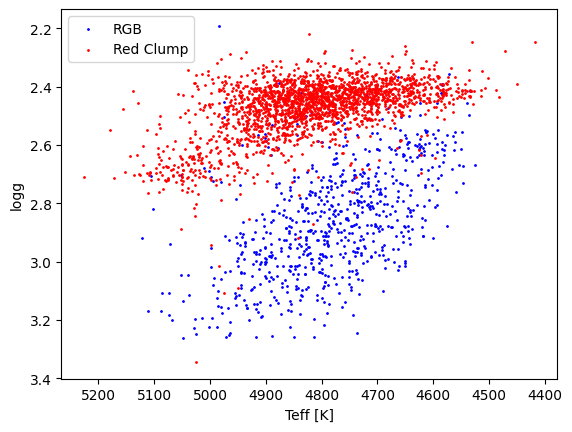

In [3]:
# Create a scatter plot for the effective temperature (Teff) vs surface gravity (logg)
# Points are color-coded: blue for RGB stars, red for Red Clump stars.

# Plot RGB stars (label = 0) in blue
plt.scatter(X[t == 0, 0], X[t == 0, 1], c="b", s=1)  # Note: I assume you meant 't' for the label based on your load data cell
# Plot Red Clump stars (label = 1) in red
plt.scatter(X[t == 1, 0], X[t == 1, 1], c="r", s=1)  # Note: I assume you meant 't' for the label based on your load data cell

# Invert the x and y axes for better visualization
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

# Add units to axis labels
plt.xlabel("Teff [K]")
plt.ylabel("logg")

# Add a legend to clarify the color coding: blue for RGB and red for Red Clump
plt.legend(["RGB", "Red Clump"], loc="upper left")


## Recap - Binary Classification with Logistic Regression

In the context of our learning process through this notebook, we aim to classify stars into one of two categories: Red Clump (RC) stars or Red Giant Branch (RGB) stars. The ground truth labels for these classifications come from asteroseismology, which is considered the gold standard in stellar classification. We use the properties for each star, represented by the feature vector $ \mathbf{x}_n $, to make our prediction.

Just like in your standard binary classification problem, the target $t_n$ for the $ n^{th} $ row is either $ 0 $ for RGB or $ 1 $ for RC. We want to learn a discriminative function $ f_{\mathbf{w}}(\mathbf{x}) $, parameterized by a weight vector $ \mathbf{w} $, to predict the star's type based on its stellar properties derived from spectra.

We assume that the pairs $ (t_n, \mathbf{x}_n) $ are i.i.d (independent and identically distributed), drawn from some hidden probability distribution. Our goal is to construct a likelihood function that tells us how likely a given weight vector $ \mathbf{w} $ could have generated our observed training data $ \{(t_n, \mathbf{x}_n)\}_{n=1}^N $.

#### Feature Map and Basis Function

In some cases, the data is not linearly separable, meaning we can't draw a straight line to neatly separate RC stars from RGB stars. However, in principle, we could apply a series of fixed, non-linear transformations to the inputs $ \mathbf{x}_n $ to create a feature space where the data becomes linearly separable. We would denote this transformation as $ \phi $, and our transformed feature vector would become $ \mathbf{\phi}_n = \phi(\mathbf{x}_n) $.

For the purpose of this notebook, we will make the simplifying assumption that $ \mathbf{\phi}_n = \mathbf{x}_n $, meaning we will work in the original feature space for now.

The first guess could be to represent the target as a linear combination of these new features: $ \hat{t}_n = \mathbf{w}^T \mathbf{\phi}_n $. However, this equation would return a real number, while $ \hat{t}_n $ needs to be either $ 0 $ or $ 1 $. 

#### Logistic Regression

In logistic regression, instead of using a hard threshold, we employ the sigmoid function $ \sigma(a) = \dfrac{1}{1 + e^{-a}} $ to transform our output into a probability measure ranging from $ 0 $ to $ 1 $. This function is smooth and differentiable, making it well-suited for gradient-based optimization algorithms.

For our two classes—RC and RGB—the probabilities $ p(C_1|\phi) $ and $ p(C_2|\phi) $ are defined as:

$$
\begin{align*}
p(C_{\mathrm{RC}}|\phi) &= \sigma (\mathbf{w}^T \phi) = y_n, \\
p(C_{\mathrm{RGB}}|\phi) &= 1 - p(C_{\mathrm{RC}}|\phi) = 1 - y_n.
\end{align*}
$$

#### Maximizing the Likelihood

Our goal is to maximize the likelihood function $ p(\mathbf{t}|\mathbf{w}) $, defined as:

$$
p(\mathbf{t}|\mathbf{w}) = \prod_{n=1}^N y_n^{t_n} (1 - y_n)^{1 - t_n}, \quad y_n = \sigma(\mathbf{w}^T \phi_n).
$$

To make the optimization tractable, we typically maximize the log-likelihood:

$$
\log p(\mathbf{t}|\mathbf{w}) = \sum_{n=1}^N ( t_n \log y_n + (1 - t_n) \log (1 - y_n) ).
$$

#### Error Function and Gradients

Our error function $ E(\mathbf{w}) $ is the negative log-likelihood, which we aim to minimize:

$$
E(\mathbf{w}) = -\sum_{n=1}^N ( t_n \log y_n + (1 - t_n) \log (1 - y_n) ).
$$

To find the optimal $\mathbf{w}$, we will resort to using stochastic gradient descent. And we have postulated in lecture that the gradient of this function with respect to $ \mathbf{w} $ is:

$$
\nabla_\mathbf{w} E(\mathbf{w}) = \sum_{n=1}^N (y_n - t_n) \phi_n.
$$

And we will show this equality in the following.

Note: To make the error metric independent of the number of data points, it is often divided by $ N $, the number of observations. 


#### Derivative of binary cross entropy

We have $ y_n = \sigma(\mathbf{w}^T \phi_n) $. The derivative of the sigma function is $ \nabla \sigma(x) = \sigma(x) \times (1 - \sigma(x)) $.

The error function is defined as:

$$
E(\mathbf{w}) = - \sum_{n=1}^N ( t_n \log y_n +  (1-t_n) \log (1-y_n) )
$$

Starting with the $ t_n \log y_n $ term:

$$
\nabla_w ( t_n \log y_n ) = t_n \nabla_w ( \log(\sigma(\mathbf{w}^T \phi_n))  )
$$

Using the chain rule:

$$
\nabla_w ( t_n \log y_n ) = t_n \dfrac{1}{\sigma(\mathbf{w}^T \phi_n)} \times \sigma(\mathbf{w}^T \phi_n) \times (1 - \sigma(\mathbf{w}^T \phi_n)) \times \phi_n
$$

Simplifying, we get:

$$
\nabla_w ( t_n \log y_n ) = t_n (1 - \sigma(\mathbf{w}^T \phi_n)) \phi_n
$$

For the $ (1-t_n) \log (1-y_n) $ term:

$$
\nabla_w ( (1- t_n) \log(1- y_n) ) = (1-t_n) \nabla_w ( \log(1-\sigma(\mathbf{w}^T \phi_n))  )
$$

Using the chain rule:

$$
\nabla_w ( (1- t_n) \log(1- y_n) ) = (1-t_n) \dfrac{1}{1-\sigma(\mathbf{w}^T \phi_n)} \times -\sigma(\mathbf{w}^T \phi_n) \times (1-\sigma(\mathbf{w}^T \phi_n)) \times \phi_n
$$

Simplifying:

$$
\nabla_w ( (1- t_n) \log(1- y_n) ) = - (1-t_n) \sigma(\mathbf{w}^T \phi_n) \phi_n
$$

Combining these terms yields:

$$
\nabla_w E(\mathbf{w}) = - \sum_{n=1}^N ( t_n (1 - \sigma(\mathbf{w}^T \phi_n)) \phi_n  - (1-t_n) \sigma(\mathbf{w}^T \phi_n) \phi_n )
$$

Grouping $ t_n $ terms and simplifying:

$$
\nabla_w E(\mathbf{w}) = - \sum_{n=1}^N ( t_n \phi_n - \sigma(\mathbf{w}^T \phi_n) \phi_n )
$$

Recognizing that $ \sigma(\mathbf{w}^T \phi_n) = y_n $, we find:

$$
\nabla_w E(\mathbf{w}) = \sum_{n=1}^N ( y_n \phi_n - t_n \phi_n )
$$

This confirms the gradient of $ E(\mathbf{w}) $ as stated earlier. Therefore, we have successfully derived the equation from the definition of the error function, setting us up for optimizing $ \mathbf{w} $ using Stochastic Gradient Descent.


## Regularization in Logistic Regression

In the Logistic Regression lecture, we discussed how to model the relationship between a set of features and a binary outcome variable. We optimized the weight vector $ \mathbf{w} $ by minimizing the binary cross-entropy loss function. However, one aspect we didn't cover was how to include a prior belief about the weights to avoid overfitting. This concept, known as regularization, was discussed in the Linear Regression lecture. Here, we'll show how to extend this idea to logistic regression by using a Gaussian prior.

#### Bayesian Framework and Regularization

As in Bayesian Linear Regression, we can introduce a Gaussian prior on the weights $ \mathbf{w} $, given by $ w \sim \mathcal{N}(\mathbf{0},\lambda^{-1}I) $, to induce regularization. We then make use of Bayes' Theorem to write the posterior $ p(\mathbf{w}|\mathbf{t}) $ as:

$$
p(\mathbf{w}|\mathbf{t}) = \frac{p(\mathbf{t}|\mathbf{w}) p(\mathbf{w})}{p(\mathbf{t})}
$$

We are interested in the negative log of this posterior, which serves as our error function $ E(\mathbf{w}) $:

$$
E(\mathbf{w}) = - \log(p(\mathbf{w}|\mathbf{t})) = -\log(p(\mathbf{t}|\mathbf{w})) + \log(p(\mathbf{w})) - \log(p(\mathbf{t}))
$$

The first term, as derived earlier, is the binary cross-entropy:

$$
- \sum_{n=1}^N ( t_n \log y_n +  (1-t_n) \log (1-y_n) )
$$

The third term doesn't depend on $ \mathbf{w} $ and can be treated as a constant that we can ignore.

#### The Regularized Error Function

The second term involves the Gaussian prior $ p(\mathbf{w}) $. Using the formula for a multivariate Gaussian, we find that this term can be simplified to:

$$
-\log(p(\mathbf{w})) = \mathrm{constant} + \dfrac{\lambda}{2} \Vert \mathbf{w} \Vert^2
$$

Putting it all together and ignoring constants, our new error function $ E(\mathbf{w}) $ becomes:

$$
E(\mathbf{w}) = - (\sum_{n=1}^N ( t_n \log y_n +  (1-t_n) \log (1-y_n) )) + \dfrac{\lambda}{2}\Vert \mathbf{w} \Vert^2
$$

This error function effectively adds a penalty term that discourages the weights from growing too large, helping to prevent overfitting. With this, we can still use techniques like Stochastic Gradient Descent to find the optimal $ \mathbf{w} $, but now under regularization.


#### Derivative of Binary Cross-Entropy with Regularization

The next task is to find the gradient of the regularized error function $ E(\mathbf{w}) $ with respect to the weight vector $ \mathbf{w} $. We already found the derivative of the first term (the binary cross-entropy loss), which was:

$$
\nabla_w E(\mathbf{w})_{\mathrm{Cross-Entropy}} = \sum_{n=1}^N ( y_n \phi_n - t_n \phi_n )
$$

The second term is the $ L_2 $ regularization term, $ \dfrac{\lambda}{2} \Vert \mathbf{w} \Vert^2 $. Taking its derivative with respect to $ \mathbf{w} $ yields:

$$
\nabla_w ( \dfrac{\lambda}{2} \Vert \mathbf{w} \Vert_2^2 ) = \lambda \mathbf{w}
$$

Therefore, when we consider the full error function $ E(\mathbf{w}) $ with the regularization term included, the gradient becomes:

$$
\nabla_w E(\mathbf{w}) = \sum_{n=1}^N ( y_n \phi_n - t_n \phi_n ) + \lambda \mathbf{w}
$$

This is the gradient we would use in an optimization algorithm like SGD to find the optimal regularized $ \mathbf{w} $. Note that the regularization term $ \lambda \mathbf{w} $ discourages the weights from growing too large, thereby mitigating the risk of overfitting.



## Recap - Stochastic Gradient Descent

Now that we have developed the mathematical foundation for logistic regression with regularization, let's implement this in code. This will give us a concrete way to find the optimal weight vector $ \mathbf{w} $ for a binary classification problem.

We'll be using the mean error function defined earlier:

$$
E(\mathbf{w}) = \dfrac{1}{N}\{-(\sum_{n=1}^N ( t_n \log y_n +  (1-t_n) \log (1-y_n))) + \dfrac{\lambda}{2}\Vert \mathbf{w} \Vert_2^2\}
$$

To optimize this cost function, we'll manually implement a Stochastic Gradient Descent (SGD) algorithm. Recall that SGD updates weights using only a subset of the entire data (a mini-batch), making it computationally more efficient than full-batch gradient descent.

#### Formulation

The key in SGD is to approximate the gradient using a mini-batch of the data. Specifically, for a mini-batch $ \mathcal{B}_i $, the stochastic gradient $ g_{\mathcal{B}_i}(\mathbf{w}_k) $ can be expressed as:

$$
g_{\mathcal{B}_i}(\mathbf{w}_k) = \dfrac{1}{N_{\mathcal{B}_i}}\{ \sum_{n=1}^N (  (y_n - t_n) \phi_n ) + \lambda \mathbf{w}\}\Bigg\vert_{\mathbf{w} = \mathbf{w}_k}
$$

The update rule for the weights then becomes:

$$
\mathbf{w}_{k+1} = \mathbf{w}_{k} - \eta g_{\mathcal{B}_i}(\mathbf{w}_k)
$$

where $\eta$ is the fixed step size (a hyperparameter).

#### Implementation

We'll implement five main functions:

1. `cost(w, X, t, a, N)`: Computes the value of the cost function for a given mini-batch.
2. `grad(w, X, t, a, N)`: Computes the stochastic gradient of the cost function for a given mini-batch.
3. `create_mini_batches(X_train, t_train, num_batches)`: Divides the training data into mini-batches.
4. `train(X_train, t_train, a, learning_rate, num_iterations, num_batches)`: Optimizes $ \mathbf{w} $ using SGD and returns it.
5. `predict(w, X)`: Given $ \mathbf{w} $ and $ X $, returns the predicted class probabilities as well as the class prediction.

#### Note

- **Data Splitting**: Use 80% of the data for training and the remaining 20% for testing.

- **Normalisation**: Before training, generally, it's generally a good idea to normalize the feature vectors. This helps in avoiding numerical instability due to features with different scales. If $ \mathbf{w}^T \phi_n $ becomes too large, the sigmoid function $ \sigma(x) $ saturates, making the gradient very small. This can cause the learning algorithm to become very slow or even fail to converge.

Now, let's dive into the implementation.

In [4]:
# Normalizing the features to have zero mean and unit variance
mean = np.mean(X, axis=0)  # Compute the mean along each feature
std = np.std(X, axis=0)    # Compute the standard deviation for each feature
X = (X - mean) / std       # Normalize the features

# Add a column of ones for the bias term in the logistic regression model
X = np.hstack((np.ones((X.shape[0], 1)), X))

# Reshape the labels into a column vector
t = t.reshape(-1, 1)  

# Shuffle the dataset and split it into training and test sets
indices = np.random.permutation(X.shape[0])  # Shuffle the indices

# Determine the splitting index
split_idx = int(0.8 * X.shape[0])

# Split the indices for the training and test sets
train_idx, test_idx = indices[:split_idx], indices[split_idx:]

# Create the training and test sets
X_train, X_test = X[train_idx, :], X[test_idx, :]
t_train, t_test = t[train_idx], t[test_idx]

We implement the key components for logistic regression:

- **Weight Initialization**: We initialize the weights randomly.
  
- **Sigmoid Function**: Serves as the activation function to squash values between 0 and 1.
  
- **Cost Function**: Evaluates the performance of the model, incorporating a regularization term.
  
- **Gradient Function**: Computes the gradient of the cost function, used for updating the weights.

These components set the stage for building, training, and optimizing our logistic regression model.

In [5]:
w = np.random.randn(X_train.shape[1])

# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Cost function
def cost(w, X, t, a, N):
    z = np.dot(X, w)
    J = -1/N * np.sum(t * np.log(sigmoid(z)) + (1 - t) * np.log(1 - sigmoid(z))) + (a/2) * np.sum(w**2)
    return J

# Gradient of the cost function
def grad(w, X, t, a, N):
    z = np.dot(X, w)
    gradient = 1/N * np.dot(X.T, (sigmoid(z) - t)) + a * w
    return gradient

We then define a function to create mini-batches of the dataset:

- **`create_mini_batches` Function**: This function takes in the features $X$, labels $t$, and the number of batches. It shuffles the dataset and splits it into smaller mini-batches.

The mini-batches will be used for stochastic gradient descent optimization, which offers a compromise between the computational intensity of batch gradient descent and the instability of stochastic gradient descent.

By dividing the data into mini-batches, we can accelerate the training process while also benefiting from more robust convergence.

In [6]:
# Create mini-batches
def create_mini_batches(X, t, num_batches):
    data = np.hstack((X, t.reshape(-1, 1)))
    np.random.shuffle(data)
    mini_batches = np.array_split(data, num_batches)
    return mini_batches

We have two main functions:

1. **`train` Function**: This function takes in the training data, regularization parameter $\lambda = a$, learning rate $\eta$, number of iterations, and number of mini-batches. It performs stochastic gradient descent to optimize the weights of the logistic regression model. The loss for each iteration is logged for further inspection.

2. **`predict` Function**: This function takes in the optimized weights and the feature matrix $X$. It returns the predicted labels as well as the probabilities associated with each prediction.

This setup enables us to train the logistic regression model using SGD and make predictions on new data. The plotted loss graph helps us to visually track the optimization process.

Let's dive into the code.

In [8]:
# Train the logistic regression model using Stochastic Gradient Descent (SGD)
def train(X_train, t_train, a, learning_rate, num_iterations, num_batches, plot_print=True):
    loss_history = []  # To keep track of the loss value at each iteration
    N, d = X_train.shape  # Number of samples and features
    w = np.zeros((d, 1))  # Initialize weights as zeros

    for i in range(num_iterations):
        # Create mini-batches for each iteration
        mini_batches = create_mini_batches(X_train, t_train, num_batches)

        # Loop over each mini-batch to update weights
        for mini_batch in mini_batches:
            X_mini, t_mini = mini_batch[:, :-1], mini_batch[:, -1].reshape(-1, 1)
            w = w - learning_rate * grad(w, X_mini, t_mini, a, X_mini.shape[0])

        # Log the current loss value
        current_loss = cost(w, X_train, t_train, a, X_train.shape[0])
        loss_history.append(current_loss)

        # Print loss every 100 iterations
        if i % 100 == 0 and plot_print:
            print(f"Iteration {i}: Loss {current_loss}")


    # Plotting the loss over iterations
    if plot_print:
        plt.plot(loss_history)
        plt.xlabel("# iterations")
        plt.ylabel("loss")
        plt.show()

    return w

# Function to predict labels and probabilities based on optimized weights
def predict(w, X, cutoff=0.5):
    z = np.dot(X, w)  # Calculate linear combination
    probabilities = sigmoid(z)  # Apply sigmoid to get probabilities
    # Convert probabilities to binary outcomes
    predictions = [1 if i >= cutoff else 0 for i in probabilities]
    return np.array(predictions).reshape(-1, 1), probabilities

### Hyperparameter Tuning, Training, and Model Evaluation

In this section, we'll first set our hyperparameters for the logistic regression model, including the regularization parameter, learning rate, number of iterations, and number of mini-batches. Next, we'll train our model on the training dataset and evaluate it on the test dataset. We'll also look at some sample predictions.


Iteration 0: Loss 0.6726411631500043
Iteration 100: Loss 0.23709040021149885
Iteration 200: Loss 0.19578737092288645
Iteration 300: Loss 0.18403052255022725
Iteration 400: Loss 0.1797150173257846
Iteration 500: Loss 0.17794873297177044
Iteration 600: Loss 0.1771815867571554
Iteration 700: Loss 0.17683598157959196
Iteration 800: Loss 0.17667679504569472
Iteration 900: Loss 0.17660226901307427


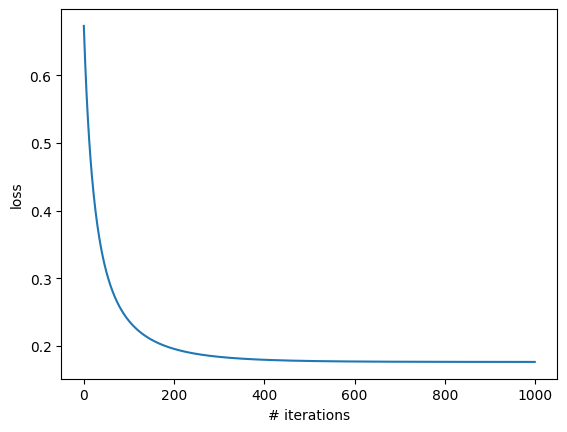

First 10 predicted classes: [[1 1 0 0 1 1 1 1 1 1]]


In [9]:
# Hyperparameter Settings
a = 0.01  # Regularization parameter (lambda)
learning_rate = 0.01  # Learning rate for gradient descent
num_iterations = 1000  # Number of iterations for gradient descent
num_batches = 10  # Number of mini-batches for SGD

# Model Training
# Invoking the 'train' function to train the model and get the optimized weights
w_train = train(X_train, t_train, a, learning_rate, num_iterations, num_batches)

# Model Evaluation
# Using the 'predict' function to get the predicted labels on the test set
t_test_pred, _ = predict(w_train, X_test)

# Sample Output
# Just displaying the first 10 predictions for illustration
print("First 10 predicted classes:", t_test_pred[:10].T)


### Understanding Classifier Performance Metrics

When assessing the performance of a binary classification model, a key tool is the **confusion matrix**. This matrix provides a deeper understanding of the predictions made by the classifier, breaking them down into four distinct outcomes:

1. **True Positives (TP)**: These are cases where the classifier correctly predicts the positive class.
2. **False Positives (FP)**: These are instances where the classifier incorrectly predicts the positive class when the actual class is negative.
3. **True Negatives (TN)**: These occur when the classifier accurately predicts the negative class.
4. **False Negatives (FN)**: Here, the classifier wrongly predicts the negative class when the actual class is positive.

The confusion matrix allows us to visualize the distribution of these outcomes, aiding in identifying areas where the classifier excels or struggles.

Now, let's discuss two important metrics derived from the confusion matrix:

1. **Accuracy**: This metric quantifies the overall correctness of the classifier's predictions. It's calculated as the ratio of correct predictions (TP and TN) to the total number of examples:

    $$
    \mathrm{Accuracy} = \dfrac{TP + TN}{\mathrm{Total examples}}
    $$

    Accuracy provides a quick snapshot of how well the model performs, but it might not be the best choice when classes are imbalanced.

2. **Balanced Accuracy**: This metric takes into account both sensitivity and specificity, making it a better choice when there's class imbalance. Sensitivity (true positive rate) is the ratio of true positives to the total actual positive examples, while specificity (true negative rate) is the ratio of true negatives to the total actual negative examples. Balanced accuracy is computed as the average of these two:

    $$
    \mathrm{Balanced Accuracy} = \dfrac{1}{2}(\frac{\mathrm{TP}}{P} + \frac{\mathrm{TN}}{N})
    $$

    Here, $ P $ represents the total number of positive examples, and $ N $ represents the total number of negative examples.

Using these metrics, we can obtain a more comprehensive understanding of our classifier's performance beyond just overall accuracy. They help us grasp how well the model handles both positive and negative class predictions, particularly when facing imbalanced datasets.


In [10]:
# Implementing the Confusion Matrix
def confusion_matrix(t_true, t_pred):
    assert len(t_true) == len(t_pred)
    
    # Initialize counts for each category in the matrix
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    
    # Count occurrences for each category
    for i in range(len(t_true)):
        if t_pred[i] == 1:
            if t_true[i] == 1:
                TP += 1
            else:
                FP += 1
        else:
            if t_true[i] == 0:
                TN += 1
            else:
                FN += 1
                
    # Return the confusion matrix as a list of lists
    return [[TN, FN], [FP, TP]]

# Implementing the Accuracy function
def accuracy(cm):
    total = sum(sum(row) for row in cm)
    return float(cm[0][0] + cm[1][1]) / total

# Implementing the Balanced Accuracy function
def balanced_accuracy(cm):
    P = cm[0][0] + cm[1][0]
    N = cm[0][1] + cm[1][1]
    return 0.5 * ((cm[0][0] / P) + (cm[1][1] / N))


We'll assess how well our trained logistic regression classifier performs on the test dataset using the defined functions for evaluation metrics.

In [11]:
# Calculate the confusion matrix for test predictions
confusion_matrix_test = confusion_matrix(t_test, t_test_pred)
print("Confusion Matrix:")
print(confusion_matrix_test)

# Calculate and display accuracy and balanced accuracy
acc = accuracy(confusion_matrix_test)
balanced_acc = balanced_accuracy(confusion_matrix_test)
print(f"Accuracy: {acc:.2f}")
print(f"Balanced Accuracy: {balanced_acc:.2f}")


Confusion Matrix:
[[146, 4], [13, 408]]
Accuracy: 0.97
Balanced Accuracy: 0.95


### Analyzing Feature Importance

Continuing our exploration of feature importance within the context of our normalized input data, we'll now focus on identifying the most impactful features by printing the top three with the highest magnitude weights.

It's worth highlighting that this analysis is particularly effective due to the normalization of our input data. Normalization ensures that the weight magnitudes provide a fair comparison across features, enabling us to directly assess their relative importance.

As anticipated, we find that the effective temperature and surface gravity features play a pivotal role in determining the classification outcome. This observation aligns perfectly with our earlier analysis, where we noticed the clear separation of red clump and RGB stars based on these features. On the other hand, auxiliary parameters like Right Ascension (RA), Declination (Dec), and others contribute comparatively less to the model's predictive power.

Executing this code allows us to precisely identify the features that wield the most influence over our logistic regression model's prediction task. This process further strengthens our initial insights and understanding of the underlying data patterns.

Feature Weights:
('bias', 1.464153019783049)
('teff', 1.1667727980145912)
('logg', -2.672540882390491)
('feh', 0.7552019442806688)
('ra', 0.00830717324900154)
('dec', 0.07026403274059788)
('J', -0.15300536497318543)
('H', -0.11575511239634431)
('K', -0.11575511239634434)
-------
Top Three Most Important Features:
['logg', 'teff', 'feh']


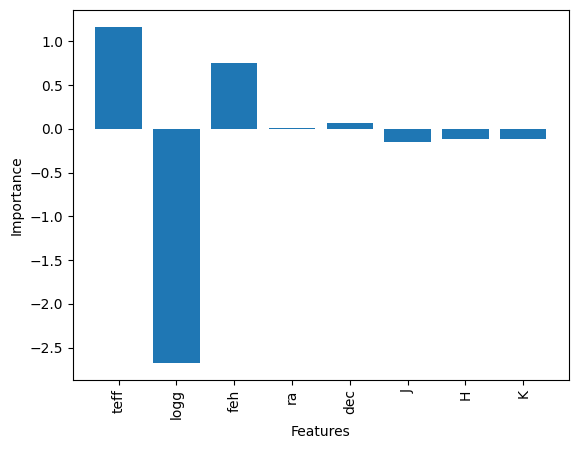

In [12]:
# Define feature columns
x_columns = ['bias', 'teff', 'logg', 'feh', 'ra', 'dec', 'J', 'H', 'K']

# Reshape the weights
w_train = w_train.reshape(-1)

# Verify length consistency
assert len(w_train) == len(x_columns)

# Plotting feature importance
plt.bar(range(len(w_train)-1), w_train[1:])
plt.ylabel('Importance')
plt.xlabel('Features')
plt.xticks(range(len(w_train)-1), x_columns[1:], rotation='vertical')

# Print feature weights
print("Feature Weights:")
print('\n'.join(map(str, list(zip(x_columns, w_train)))))
print('-------')

# Identify the top three important features based on the weight magnitude
top_feature_indices = np.argsort(np.abs(w_train[1:]))[::-1][:3]
top_features = [x_columns[i+1] for i in top_feature_indices]
print("Top Three Most Important Features:")
print(top_features)

### Understanding the Impact of Regularization and Batch Size on Model Performance

#### Why Study Regularization?

The regularization parameter $ \lambda $ is crucial for preventing overfitting in machine learning models. By penalizing large weight values, regularization helps the model generalize better to unseen data. However, setting $ \lambda $ too high can lead to underfitting, where the model is unable to capture the complexities in the data. Thus, choosing an optimal $ \lambda $ is critical.

#### Why Study Batch Size?

Batch size controls the number of samples that are used to update the model's weights in each iteration of Stochastic Gradient Descent (SGD). A smaller batch size often provides a regularization effect and lower generalization error. However, it also means that the model takes longer to converge. Larger batches, on the other hand, can lead to quicker but potentially less accurate models.

To find the best combination of $ \lambda $ and batch size, we employ a grid search. A grid search allows us to systematically work through multiple combinations of hyperparameters, cross-verify each one, and determine which one gives the best performance in terms of Balanced Accuracy.

Now we'll implement the grid search as previously explained in the code snippet. This script will train multiple models with different combinations of $ \lambda $ and batch sizes, and it will evaluate each model using the Balanced Accuracy metric.


In [13]:
# Hyperparameter Grid
lambda_options = [0.0001, 0.001, 0.01, 0.1, 1, 10]  # Regularization parameter
batch_size_options = [3, 10, 30, 100, 300, 1000]  # Batch sizes

best_balanced_acc = 0  # To keep track of the best balanced accuracy
best_lambda = None  # To keep track of the best regularization parameter
best_batch_size = None  # To keep track of the best batch size

# Dictionary to store balanced accuracy results
balanced_accuracy_results = {}

# Grid Search
for lambda_val in lambda_options:
    for batch_size in batch_size_options:
        print(f"Training with lambda {lambda_val} and batch size {batch_size}...")
        
        # Train the model
        w_train = train(X_train, t_train, lambda_val, learning_rate, num_iterations, batch_size, plot_print=False)
        
        # Make predictions and calculate Balanced Accuracy
        t_test_pred, _ = predict(w_train, X_test)
        confusion_matrix_test = confusion_matrix(t_test, t_test_pred)
        balanced_acc = balanced_accuracy(confusion_matrix_test)
        
        # Log the balanced accuracy for this parameter combination
        balanced_accuracy_results[(lambda_val, batch_size)] = balanced_acc
        
        print(f"Balanced Accuracy: {balanced_acc:.3f}")
        
        # Update best hyperparameters if current Balanced Accuracy is better
        if balanced_acc > best_balanced_acc:
            best_balanced_acc = balanced_acc
            best_lambda = lambda_val
            best_batch_size = batch_size

print(f"Best Balanced Accuracy: {best_balanced_acc:.3f} achieved with lambda {best_lambda} and batch size {best_batch_size}")


Training with lambda 0.0001 and batch size 3...
Balanced Accuracy: 0.948
Training with lambda 0.0001 and batch size 10...
Balanced Accuracy: 0.959
Training with lambda 0.0001 and batch size 30...
Balanced Accuracy: 0.962
Training with lambda 0.0001 and batch size 100...
Balanced Accuracy: 0.962
Training with lambda 0.0001 and batch size 300...
Balanced Accuracy: 0.962
Training with lambda 0.0001 and batch size 1000...
Balanced Accuracy: 0.962
Training with lambda 0.001 and batch size 3...
Balanced Accuracy: 0.948
Training with lambda 0.001 and batch size 10...
Balanced Accuracy: 0.959
Training with lambda 0.001 and batch size 30...
Balanced Accuracy: 0.962
Training with lambda 0.001 and batch size 100...
Balanced Accuracy: 0.962
Training with lambda 0.001 and batch size 300...
Balanced Accuracy: 0.962
Training with lambda 0.001 and batch size 1000...
Balanced Accuracy: 0.959
Training with lambda 0.01 and batch size 3...
Balanced Accuracy: 0.948
Training with lambda 0.01 and batch size 

Visualizing the impact of hyperparameters can provide valuable insights into the model's behavior. A heatmap can help you quickly understand how Balanced Accuracy changes with $ \lambda $ and batch size.

By examining this heatmap, you can visualize how Balanced Accuracy varies across different settings. Regions with warmer colors indicate higher Balanced Accuracy, helping you to quickly identify which hyperparameters are promising for further exploration.


Text(0.5, 1.0, 'Balanced Accuracy for different Lambda and Batch Sizes')

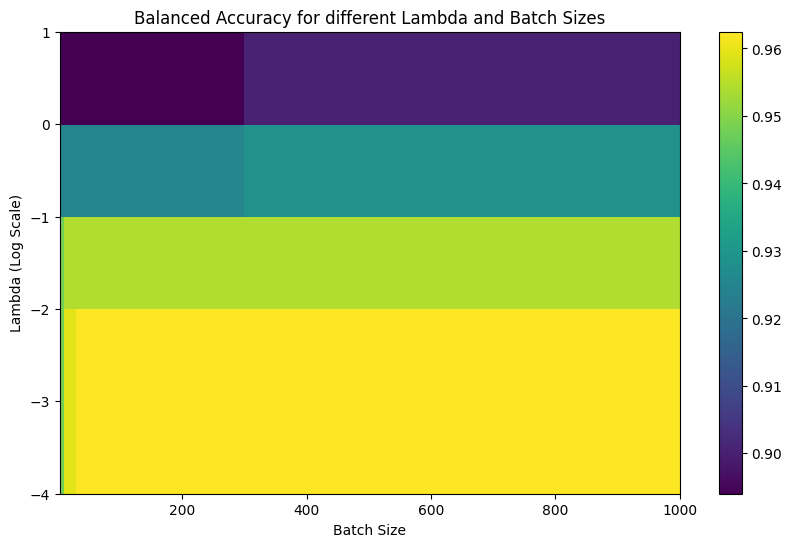

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Separate keys and values for plotting
keys = list(balanced_accuracy_results.keys())
values = list(balanced_accuracy_results.values())

# Create a 2D array to hold the balanced accuracy values
acc_matrix = np.zeros((len(lambda_options), len(batch_size_options)))

for i, lambda_val in enumerate(lambda_options):
    for j, batch_size in enumerate(batch_size_options):
        acc_matrix[i, j] = balanced_accuracy_results[(lambda_val, batch_size)]

plt.figure(figsize=(10, 6))

# Create the heatmap
c = plt.pcolormesh(batch_size_options, np.log10(lambda_options), acc_matrix, shading='auto', cmap='viridis')
plt.colorbar(c)

# Add labels and title
plt.xlabel('Batch Size')
plt.ylabel("Lambda (Log Scale)")
plt.title("Balanced Accuracy for different Lambda and Batch Sizes")


Best Lambda: 0.0001, Best Batch Size: 30
Iteration 0: Loss 0.6352765496952928
Iteration 100: Loss 0.12816416322778823
Iteration 200: Loss 0.10431290514088445
Iteration 300: Loss 0.09698099252585447
Iteration 400: Loss 0.09379681339913593
Iteration 500: Loss 0.09217182558662743
Iteration 600: Loss 0.09126165256305704
Iteration 700: Loss 0.09071991753215594
Iteration 800: Loss 0.09038358072151866
Iteration 900: Loss 0.09016834873820169


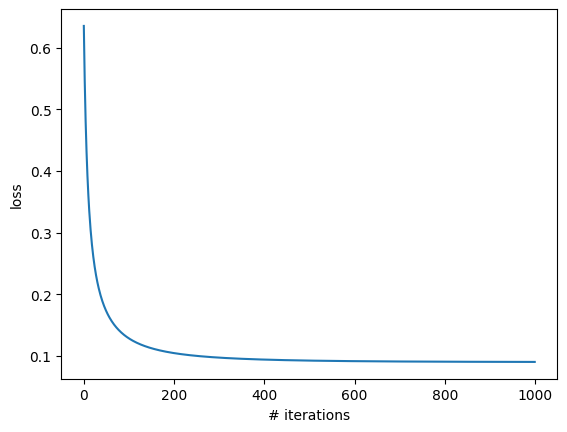

In [15]:
# Find the best lambda and batch size based on balanced accuracy
best_lambda, best_batch = max(balanced_accuracy_results, key=balanced_accuracy_results.get)
print(f"Best Lambda: {best_lambda}, Best Batch Size: {best_batch_size}")

# Retrain the model using the best lambda
w_best_lambda = train(X_train, t_train, best_lambda, learning_rate, num_iterations, best_batch)


### Plotting the Decision Boundary for Class Separation

Finally, we'll visualize how well our trained logistic regression model performs by plotting a decision boundary. This is a line (or in higher dimensions, a hyperplane) that separates the data points of different classes.

You may notice that our dataset has multiple features, not just `Teff` and `logg` that we wish to plot. This poses a challenge since the decision boundary is influenced by all these features, and we're interested in seeing it projected onto the `Teff-logg` plane.

To tackle this challenge, we'll hold the other features constant at their median values. The idea is that by setting these features to their median values, we can observe how the model behaves, specifically in relation to `Teff` and `logg`, without the added complexity of the other features.

In particular, in the following, we will create a grid of points that spans the feature space for `Teff` and `logg`. For each point in this grid, we append the median values of all other features. We then use our trained model to make predictions for each point in this newly created feature space.

Finally, we plot the `Teff-logg` plane and color it based on the predictions. A point will get colored based on the class the model predicts for a data point at that position, assuming other features are at their median values.


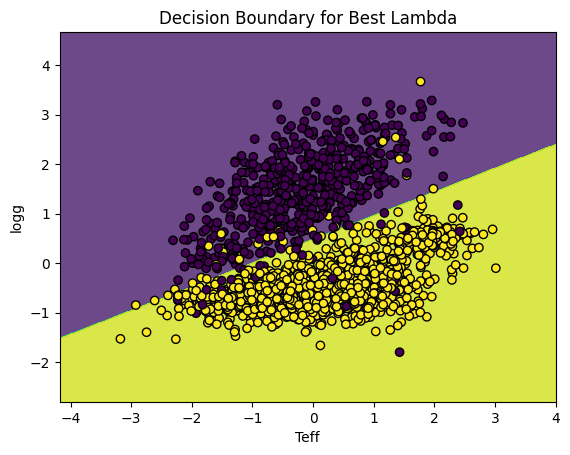

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Define a function to plot the decision boundary
def plot_decision_boundary(X, t, w):
    h = .02  # Step size in the mesh
    # Create a mesh to plot in
    x_min, x_max = X[:, 1].min() - 1, X[:, 1].max() + 1  # Teff is at index 1 after adding bias term
    y_min, y_max = X[:, 2].min() - 1, X[:, 2].max() + 1  # logg is at index 2 after adding bias term
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Calculate the median of other features
    median_values = np.median(X[:, 3:], axis=0)  # the other features start from index 3
    
    # Adding Bias Term
    bias = np.ones((xx.ravel().shape[0], 1))
    
    # Create 2D mesh points for Teff and logg
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    
    # Replicate the median values to match the shape of mesh_points
    replicated_median_values = np.tile(median_values, (mesh_points.shape[0], 1))
    
    # Combine Teff, logg mesh points with median values of other features
    combined_features = np.hstack([mesh_points, replicated_median_values])
    
    # Combine bias and features
    mesh_points_with_bias = np.hstack([bias, combined_features])
    
    # Make predictions on the mesh points
    Z, _ = predict(w, mesh_points_with_bias)
    Z = Z.reshape(xx.shape)

    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 1], X[:, 2], c=t.ravel(), edgecolors='k', marker='o', linewidth=1)  # Adjust indices to match the positions of Teff and logg in your dataset
    plt.xlabel('Teff')
    plt.ylabel('logg')
    plt.title('Decision Boundary for Best Lambda')

plot_decision_boundary(X_train, t_train, w_best_lambda)
plt.show()


### Conclusion:

In this comprehensive tutorial, we embarked on a journey through the landscape of logistic regression, a cornerstone technique in machine learning for binary classification.

#### Key Takeaways:

1. **Mathematical Foundations**: We started by understanding the core mathematical concepts, like the sigmoid function and the logistic loss, which serve as the backbone of logistic regression.
  
2. **Model Training**: We introduced Stochastic Gradient Descent (SGD) as a means to optimize our logistic regression model. Utilizing mini-batches, we demonstrated how to iteratively update the weights to minimize the loss function.

3. **Hyperparameter Tuning**: We discussed the importance of various hyperparameters like the regularization term (lambda in this context), learning rate, and batch size. We even showed how to systematically search through these using a grid search approach for optimal performance.

4. **Performance Metrics**: We delved into the confusion matrix and derived performance metrics like accuracy and balanced accuracy to evaluate the model's robustness, especially in situations where class imbalance might distort regular accuracy measurements.

#### Final Thoughts:

The power of logistic regression lies not just in its simplicity but also in its versatility. As we've shown, it can be adapted and fine-tuned in various ways to fit specific needs and challenges. Whether you're just getting started in machine learning or you're a seasoned practitioner, we hope this tutorial has provided you with valuable insights into the inner workings, optimization, and evaluation of logistic regression models.
